## Competition documentation

[Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality)

## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from pathlib import Path
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
SEED=7

## Reading data

In [2]:
path = Path('../input/linking-writing-processes-to-writing-quality')
path_keystroke_measures = Path('../input/keystroke-measures/train_logs.pkl')

In [3]:
os.listdir(path)

['sample_submission.csv',
 'test_logs.csv',
 'train_scores.csv',
 'train_logs.csv']

In [4]:
test_logs = pd.read_csv(path/'test_logs.csv')
sample_submission = pd.read_csv(path/'sample_submission.csv')
train_scores = pd.read_csv(path/'train_scores.csv')

with open(path_keystroke_measures, 'rb') as file:
    train_logs = pd.read_pickle(file)

DEBUG = False   
    
if DEBUG:
    num_essays = 100
    train_logs = train_logs[train_logs.id.isin(train_logs.id.unique()[:num_essays])]
    train_scores = train_scores[train_scores.id.isin(train_logs.id.unique()[:num_essays])]
    print(f"Debug mode activated. Utilizing {num_essays} essays from train_logs and train_scores.")
else:
    print("Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized:",
          f"{train_logs.id.nunique()} essays.")

Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized: 2471 essays.


## EDA

`test_logs` includes data for 3 essays. It is meant to serve as an example to illustrate the format.

The real `test_logs` will replace it when submissions are scored, according to the competition documentation. 

In [5]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [6]:
sample_submission

,id,score
0,0000aaaa,1.0
1,2222bbbb,2.0
2,4444cccc,3.0


### **score** - target variable

The average score is 3.71. The median is 4.0
There are 12 possible values for essay score: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0] 


here score
7.0     501
6.0     486
8.0     402
5.0     336
4.0     201
9.0     179
10.0    128
3.0      92
2.0      69
11.0     37
1.0      35
0.0       5
Name: count, dtype: int64


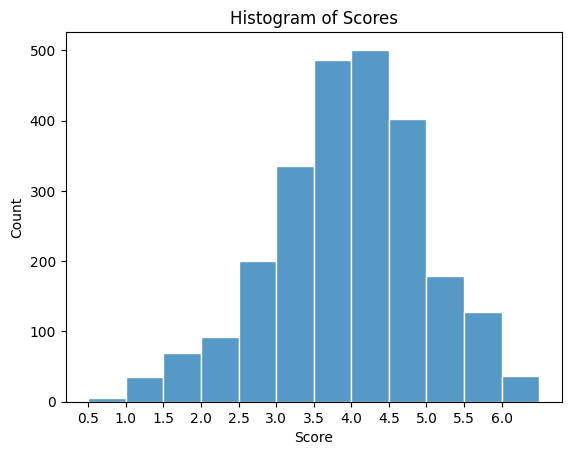

The score 0.5 is represented by only five data points, all of which register as zero.

Changing type to Categorical:
 [6.0, 11.0, 3.0, 7.0, 8.0, ..., 5.0, 2.0, 10.0, 1.0, 0.0]
Length: 12
Categories (12, float64): [0.0 < 1.0 < 2.0 < 3.0 ... 8.0 < 9.0 < 10.0 < 11.0]


In [7]:
print(f'The average score is {train_scores.score.mean().round(2)}. The median is {train_scores.score.median()}')

sns.histplot(train_scores.score, bins=12, edgecolor='white', binwidth=0.4999)
xticks = [0.5 * i for i in range(1, 13)]
plt.xticks(xticks)
plt.xlabel('Score');
plt.ylabel('Count');
plt.title('Histogram of Scores')

print(f'There are {train_scores.score.nunique()} possible values for essay score:', 
      sorted(train_scores.score.unique()), '\n\n')

train_scores.score = train_scores.score*2 - 1
print('here', train_scores.score.value_counts())

train_scores.score = pd.Categorical(train_scores.score, sorted(train_scores.score.unique()), ordered=True)
plt.show()
print('The score 0.5 is represented by only five data points, all of which register as zero.\n')
print('Changing type to Categorical:\n', train_scores.score.unique())

### train_logs

In [8]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,num_events,total_time_mins,total_action_time_mins,mean_action_time_ms,chars_product,chars_per_min_product,chars_process,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,num_pauses,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2


#### train_logs --> simplified_train_logs

Ultimately, we will retain only a single row for each essay:

In [9]:
redundant_vars = ['num_pauses', 'chars_process', 'chars_product']
train_logs.drop(redundant_vars, axis=1, inplace=True)

original_cols_ex_id = ['event_id', 'down_time', 'up_time', 'action_time', 'activity',
                       'down_event', 'up_event', 'text_change', 'cursor_position', 'word_count']

simplified_train_logs = train_logs.drop(original_cols_ex_id, axis=1)

simplified_train_logs.drop_duplicates(inplace=True)
simplified_train_logs.reset_index(drop=True, inplace=True)

print("\nNumber of features in train_logs vs simplified_train_logs:",len(train_logs.columns), 'vs', len(simplified_train_logs.columns), '\n')
print("Number of rows in train_logs vs simplified_train_logs:",train_logs.shape[0], 'vs', simplified_train_logs.shape[0], '\n')
simplified_train_logs.head()


Number of features in train_logs vs simplified_train_logs: 46 vs 36 

Number of rows in train_logs vs simplified_train_logs: 8405898 vs 2471 



,id,num_events,total_time_mins,total_action_time_mins,mean_action_time_ms,chars_per_min_product,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval
0,001519c8,2557,30.0,5.0,116.2,50.9,67.2,8.5,11.6,0.7,21.8,0.1,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
1,0022f953,2454,29.8,4.6,112.2,56.2,65.1,10.7,12.4,0.6,17.9,0.2,2.7,65.8,14521.8,NaN,3197.7,1207.0,784.3,82.0,2.8,3.2,8.0,0.0,74.0,0.1,0.9,8.0,20.0,0.3,0.7,34.9,37.2,3.1,8.3,8.3
2,0042269b,4136,29.5,7.0,101.8,87.7,119.4,13.7,18.6,0.7,20.9,0.6,2.6,62.8,14430.7,4804.0,3315.3,1637.2,492.0,97.0,3.3,4.5,5.0,0.0,92.0,0.1,0.7,17.0,47.0,0.6,1.6,39.9,39.4,4.1,12.1,3.7
3,0059420b,1556,23.4,3.2,121.8,49.3,56.3,8.8,10.4,0.6,13.0,0.1,3.7,54.7,8828.4,61128.7,14315.4,2824.9,1199.7,66.0,2.8,2.3,1.0,0.0,65.0,0.0,0.9,4.0,3.0,0.2,0.1,27.5,28.7,3.4,2.1,2.8
4,0075873a,2531,27.7,5.2,123.9,51.4,70.1,9.1,12.2,0.9,24.7,0.4,3.2,62.9,11880.3,37640.0,12462.1,2293.4,1212.0,58.0,2.1,8.9,8.0,0.0,50.0,0.1,0.7,16.0,8.0,0.6,0.3,47.2,32.2,9.1,3.0,3.8


#### down_time, up_time, action_time

These 3 features have been used to create several other features in the `keystroke-measures` file, 

namely `total_time_mins, total_action_time_mins, mean_action_time_ms` and features related to pauses, deletions and bursts.

#### activity

Values like `Move From [x1, y1] To [x2, y2]` in the field `activity` refer to events where a section of text has been moved to a new location.

In [10]:
print("The number of events with this kind of activity is only:", 
      train_logs[train_logs['activity'].str.startswith('Move From [')].activity.count())

The number of events with this kind of activity is only: 46


In [11]:
print("Value counts for other types of activity are:\n\n", 
      train_logs[~train_logs['activity'].str.startswith('Move')].activity.value_counts())

Value counts for other types of activity are:

 activity
Input            6726796
Remove/Cut        970158
Nonproduction     703851
Replace             4448
Paste                599
Name: count, dtype: int64


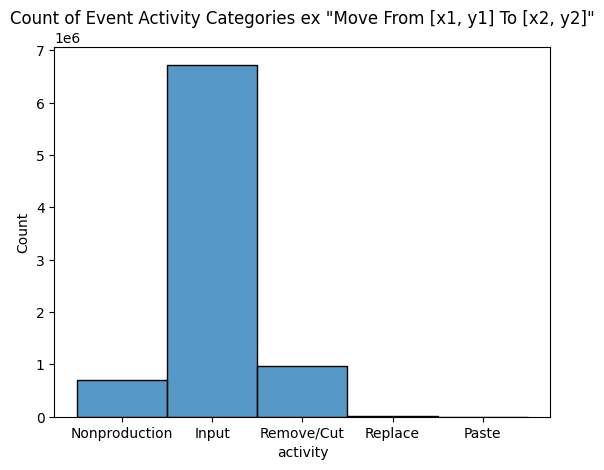

In [12]:
sns.histplot(train_logs[~train_logs['activity'].str.startswith('Move')].activity);
plt.title('Count of Event Activity Categories ex "Move From [x1, y1] To [x2, y2]"');

#### down_event, up_event, text_change 

The documentation specifies that all alphanumeric character inputs have been substituted with the "anonymous" character `q`.

In [13]:
train_logs.text_change.value_counts()[:10]

text_change
q           6128208
            1376829
NoChange     703851
.             67797
,             54797
\n            27977
'             13192
"              4659
-              4492
?              3507
Name: count, dtype: int64

In [14]:
train_logs.down_event.unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [15]:
train_logs.down_event.value_counts()[:10]

down_event
q             5365319
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
Leftclick       91126
ArrowLeft       63217
.               59586
,               46806
ArrowDown       30874
Name: count, dtype: int64

- **Hypothesis to explore**: Better handling of keyboard shortcuts could be associated with higher competence

In [16]:
# We will focus on 'Control key' events
train_logs['num_control_key'] = train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())

simplified_train_logs = simplified_train_logs.merge(train_logs[['id', 'num_control_key']].drop_duplicates(), on='id', how='left')
simplified_train_logs.drop('id', axis=1, inplace=True)
simplified_train_logs.num_control_key.value_counts()

num_control_key
0      2015
1       167
2        82
4        30
3        25
7        18
6        15
5        14
9         8
11        6
16        5
10        5
12        5
13        5
8         5
24        4
23        4
20        3
14        3
17        3
39        3
250       2
56        2
18        2
22        2
26        2
15        2
29        2
30        2
31        1
63        1
58        1
176       1
95        1
19        1
53        1
81        1
78        1
89        1
98        1
76        1
46        1
80        1
75        1
77        1
156       1
74        1
49        1
55        1
92        1
99        1
32        1
27        1
64        1
113       1
48        1
37        1
117       1
132       1
Name: count, dtype: int64

In [17]:
# Verifying that the choice between 'down_event' and 'up_event' is inconsequential
is_choice_irrelevant = (train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())
                        == train_logs.groupby('id')['up_event'].transform(lambda x: (x == 'Control').sum())).mean()

print(f"The result of is_choice_irrelevant: {bool(is_choice_irrelevant)},", 
      "confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.")

The result of is_choice_irrelevant: True, confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.


Percentage of essays with at least one event ('down_event') involving the Control key: 18.5%




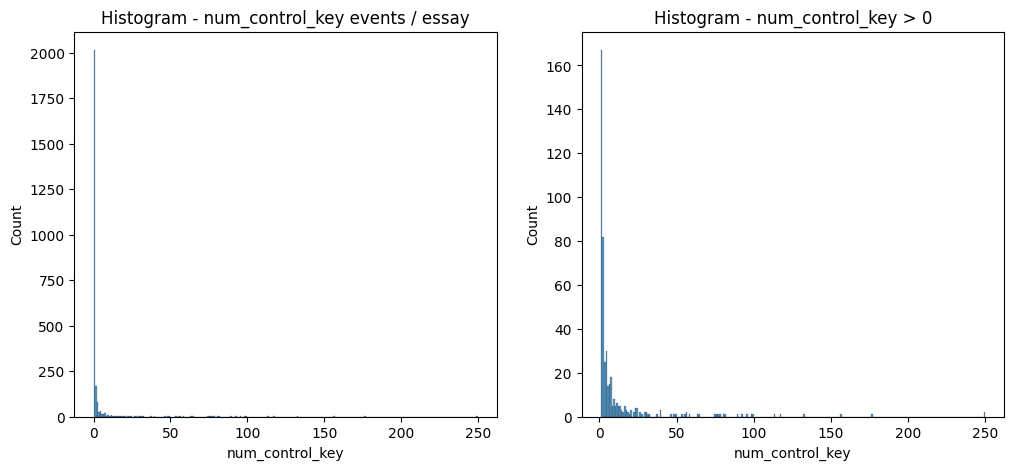

In [18]:
# Observing values of new feature 'num_control_key'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(simplified_train_logs.num_control_key, binwidth=1, ax=axes[0])
axes[0].set_title('Histogram - num_control_key events / essay')

sns.histplot(simplified_train_logs[simplified_train_logs.num_control_key > 0].num_control_key, binwidth=1, ax=axes[1])
axes[1].set_title('Histogram - num_control_key > 0');

print("Percentage of essays with at least one event ('down_event') involving the Control key:",
      f"{np.round(100 * len(simplified_train_logs[simplified_train_logs.num_control_key != 0]) / len(simplified_train_logs), 1)}%\n\n")

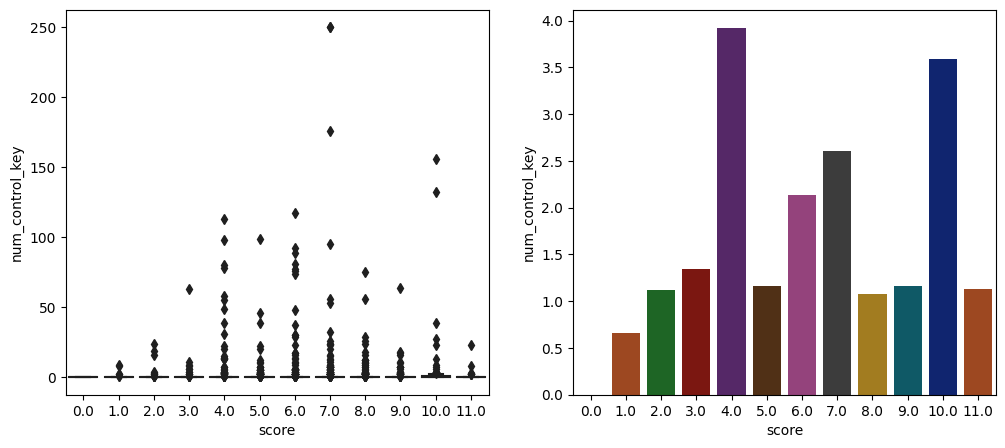

In [19]:
# Checking correlation of 'num_control_key' vs 'score'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_control_key, palette='dark', ax=axes[0]);
sns.barplot(x=train_scores.score, y=simplified_train_logs.num_control_key, ci=None, palette='dark', ax=axes[1]);

We can infer that there is no discernible correlation between use of 'Control key' vs 'score'. 

Nevertheless, we will keep the feature for potential interactions with other features.

#### num_events

The average number of events per essay is 3402.0


<Axes: xlabel='num_events', ylabel='Count'>

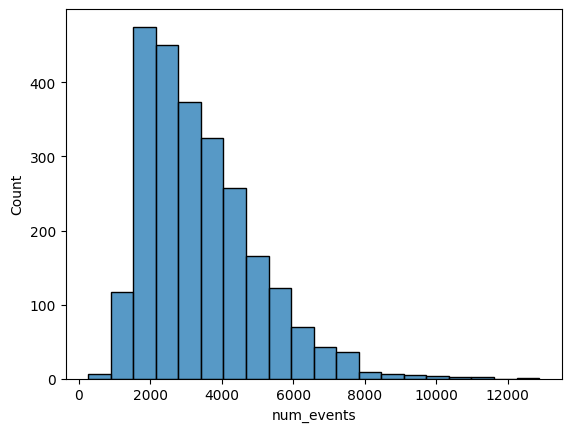

In [20]:
print(f'The average number of events per essay is {np.round(simplified_train_logs.num_events.mean(), 0)}')
sns.histplot(data=simplified_train_logs, x='num_events', bins=20)

For machine learning models, it becomes challenging to effectively learn and make accurate predictions when certain features

exhibit a range of values with infrequent occurrences. We will try some approaches to mitigate that handicap, later on.

Is there a correlation between `num_events` and `score`?


				The graph on the right illustrates the average value of num_events for each score.




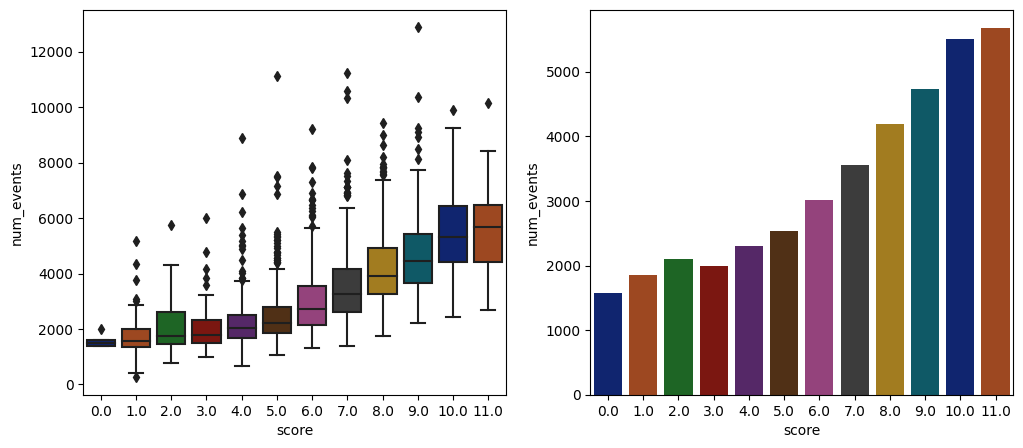

In [21]:
print("\n\t\t\t\tThe graph on the right illustrates the average value of num_events for each score.\n\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_events, palette='dark', ax=axes[0]);
sns.barplot(x=train_scores.score, y=simplified_train_logs.num_events, ci=None, palette='dark', ax=axes[1]);

Indeed, there appears to be a positive correlation between `num_events` and `score`.

Now, let's check possible correlations between the target variable `score` and the rest of features:

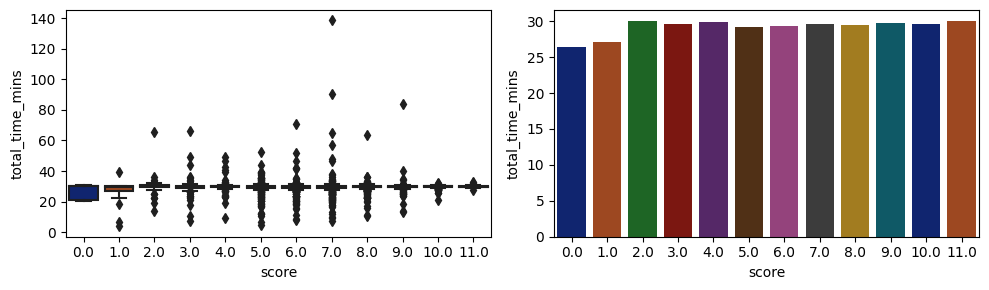

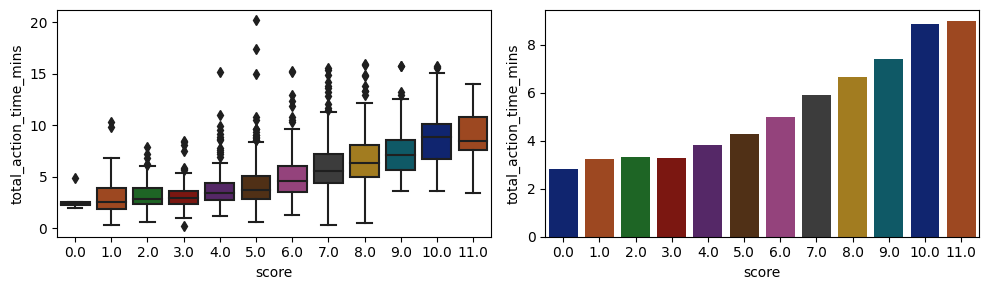

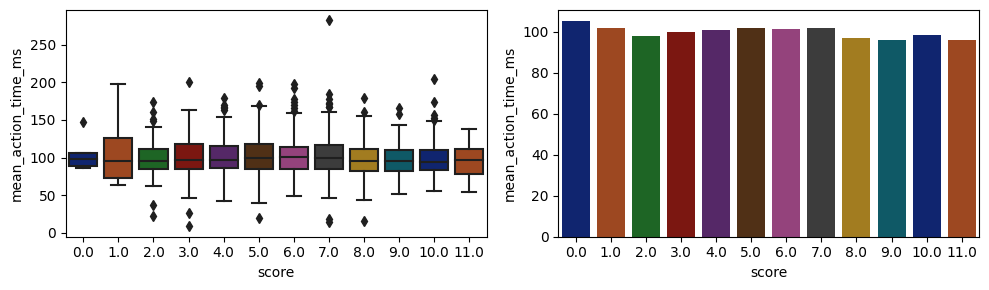

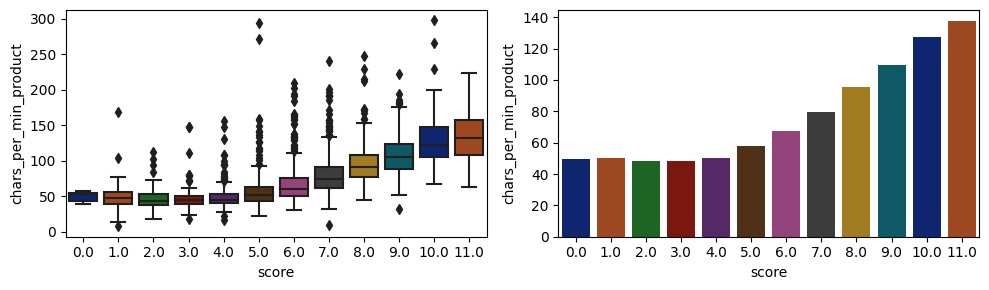

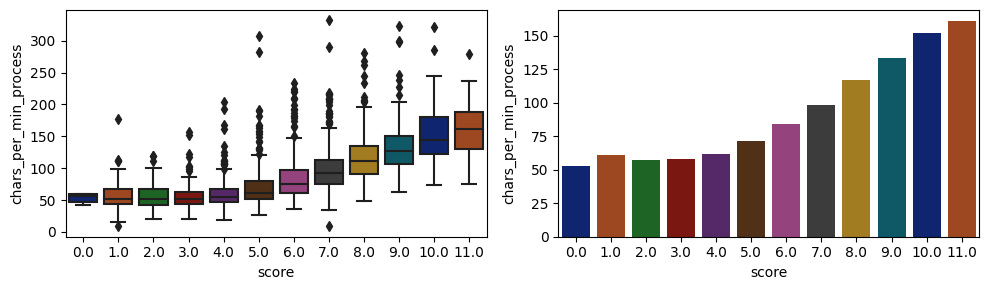

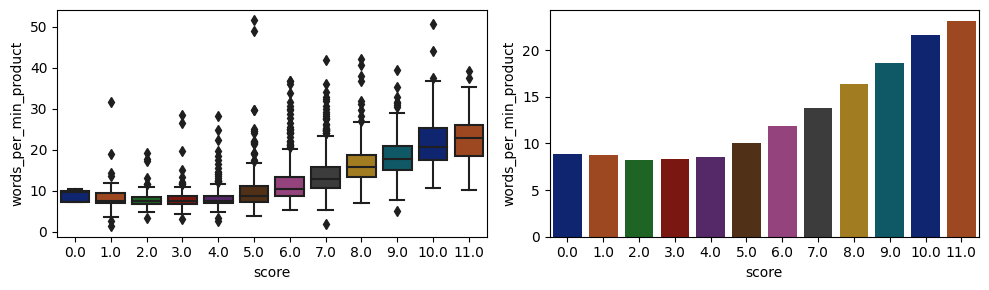

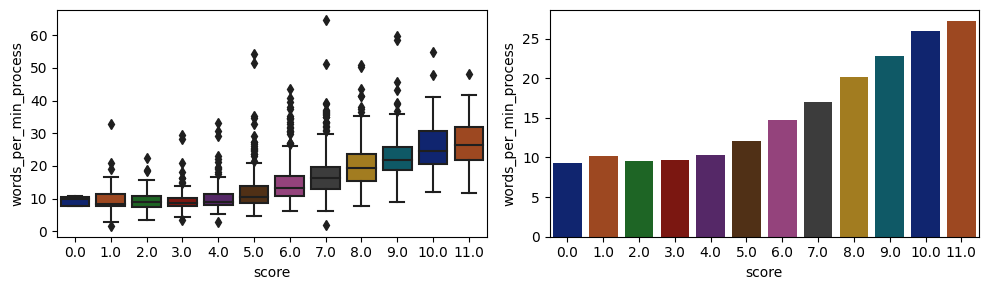

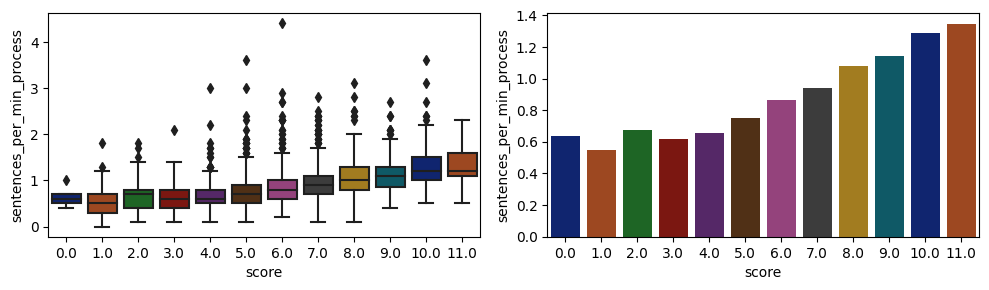

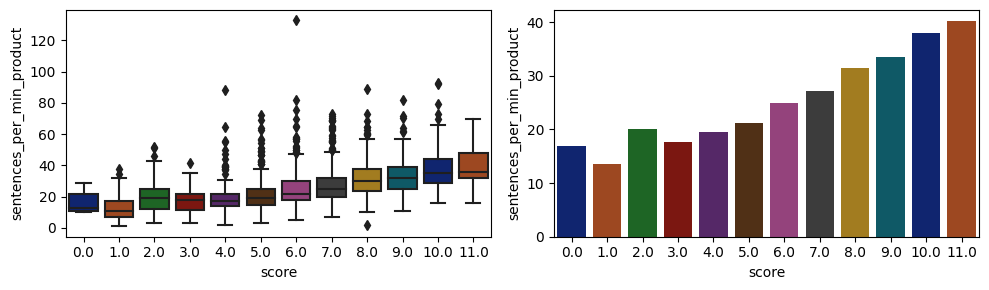

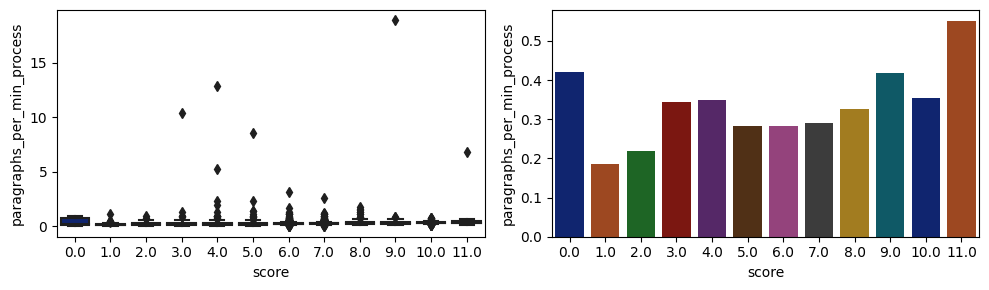

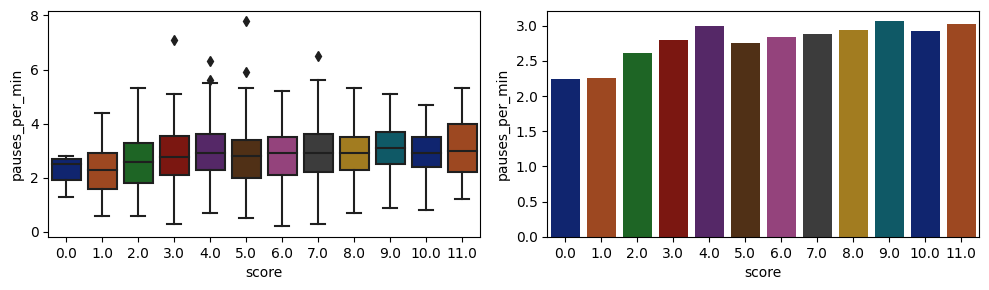

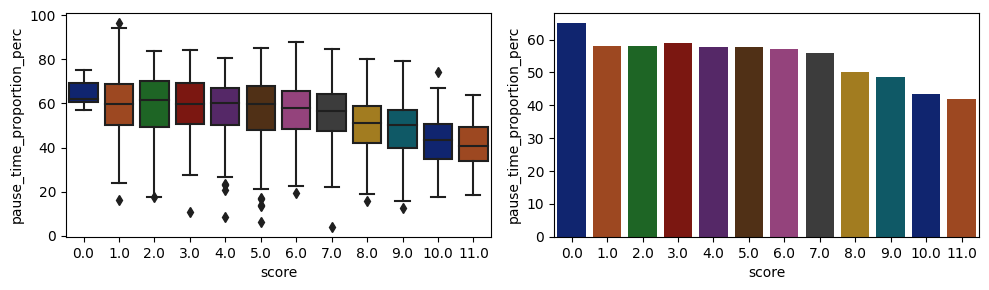

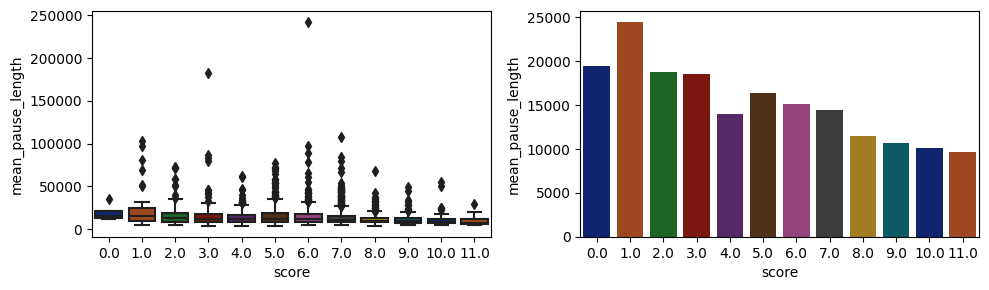

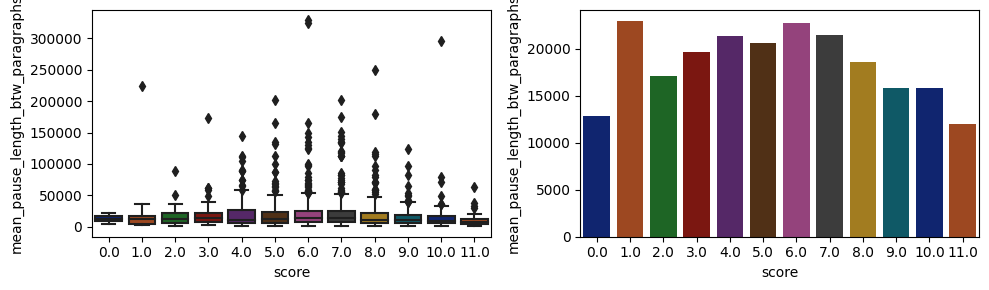

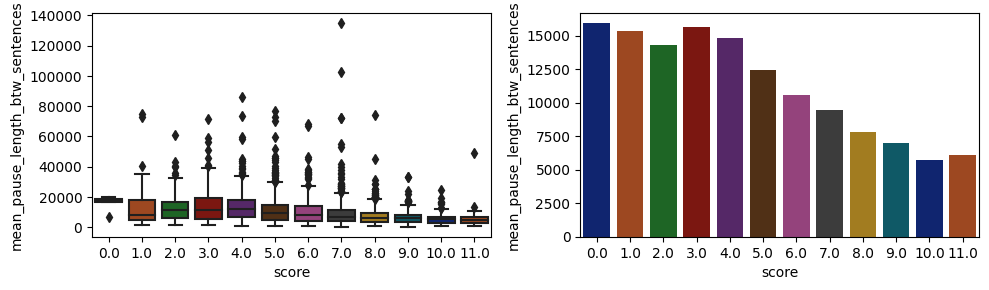

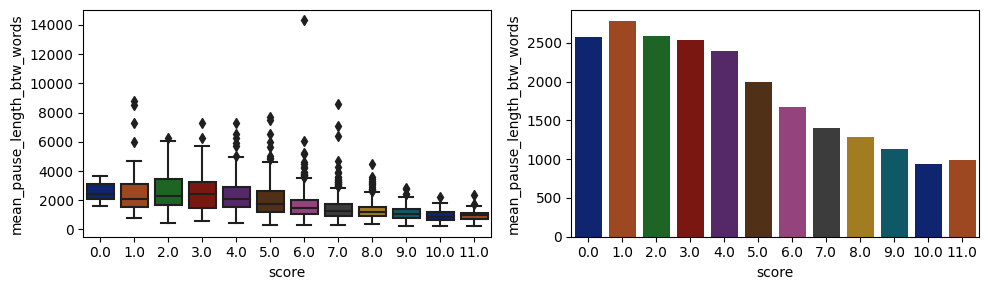

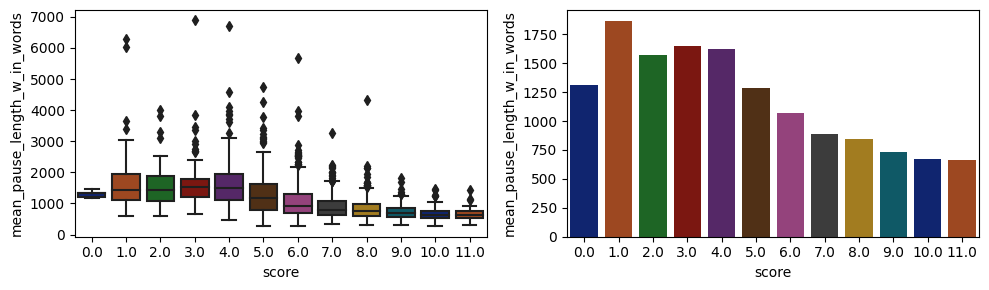

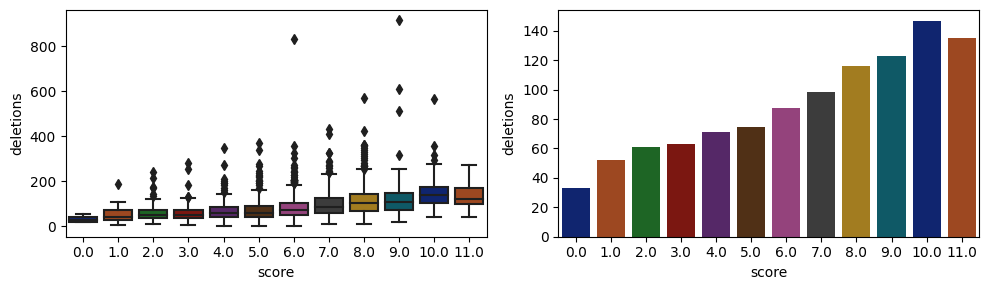

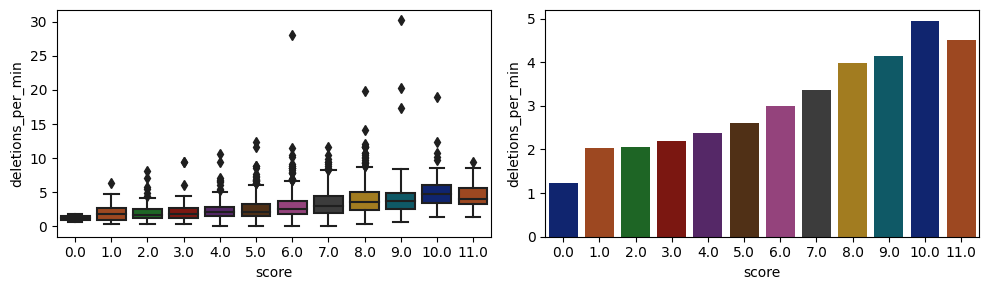

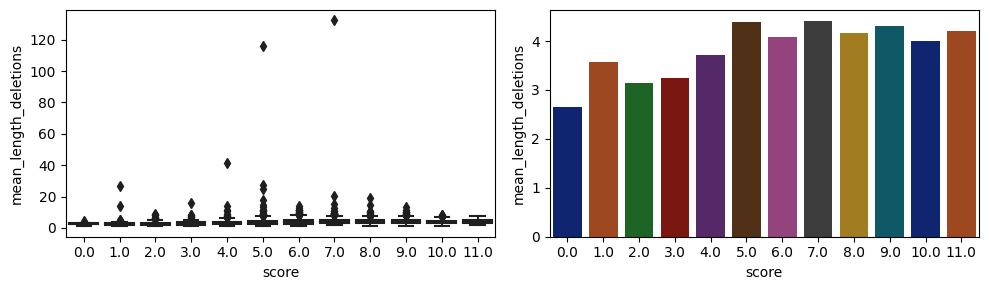

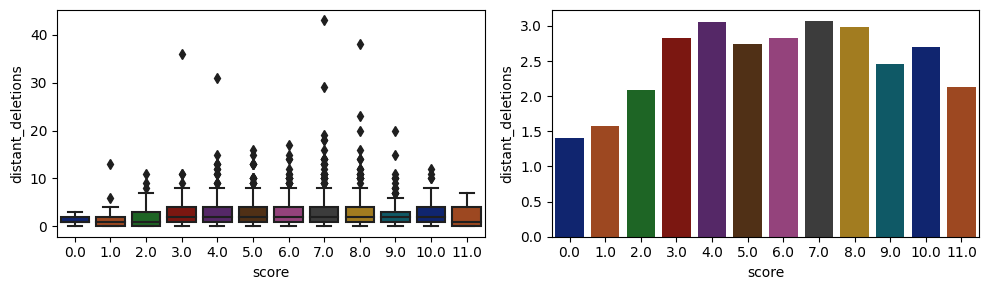

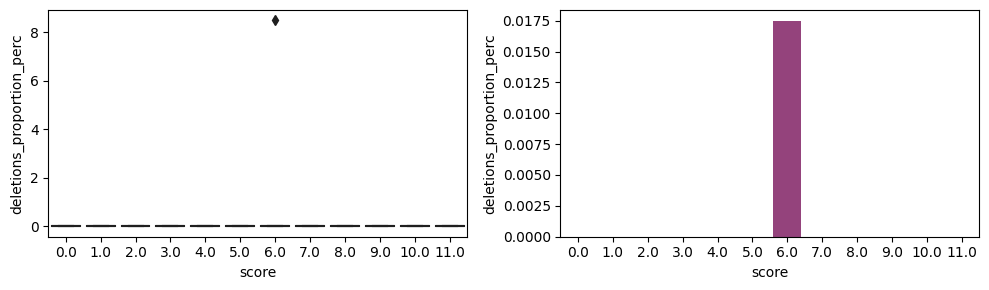

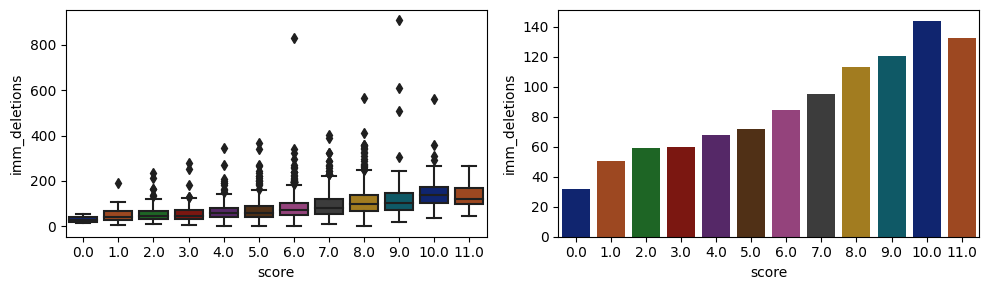

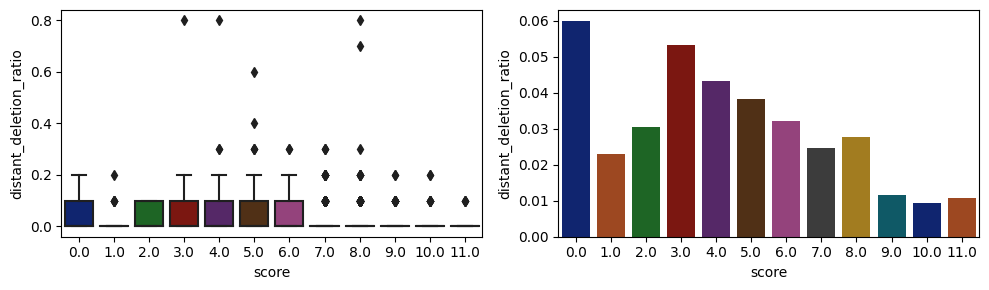

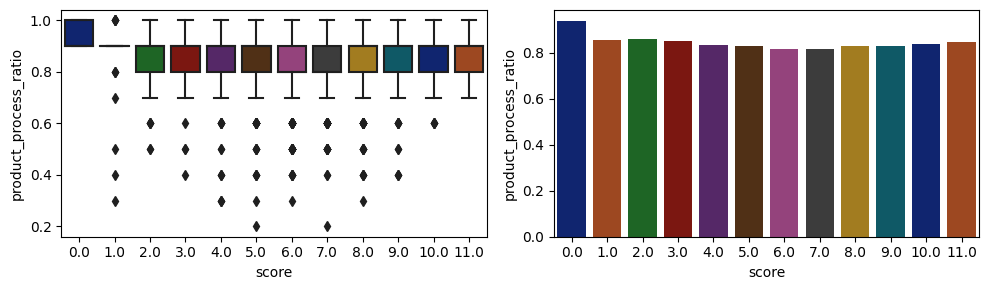

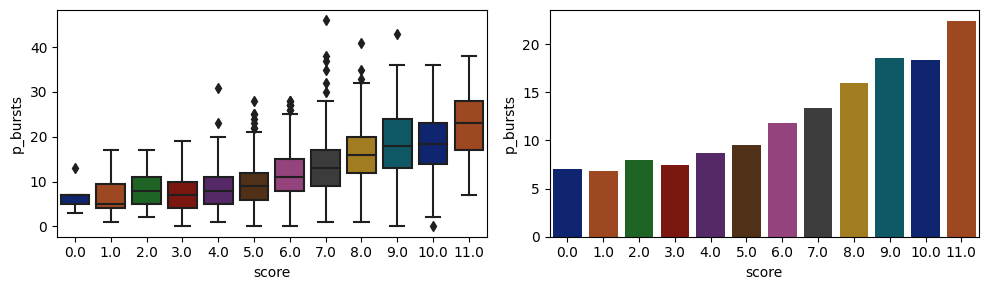

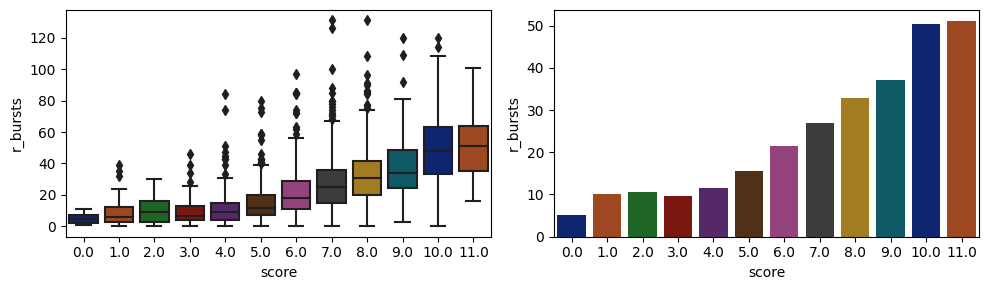

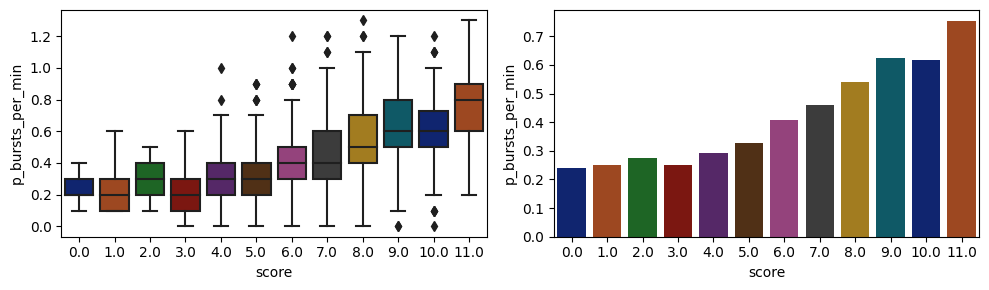

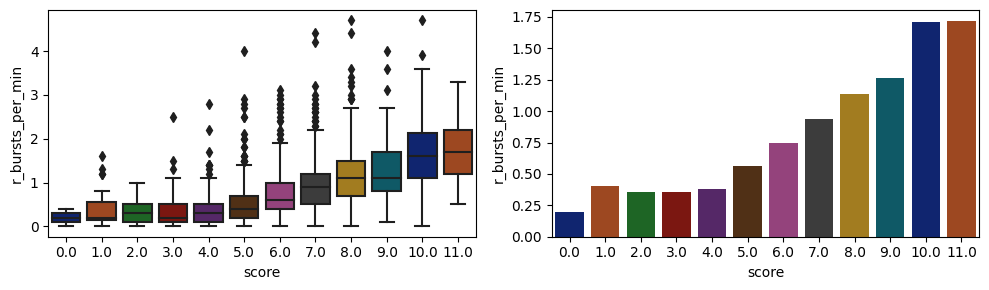

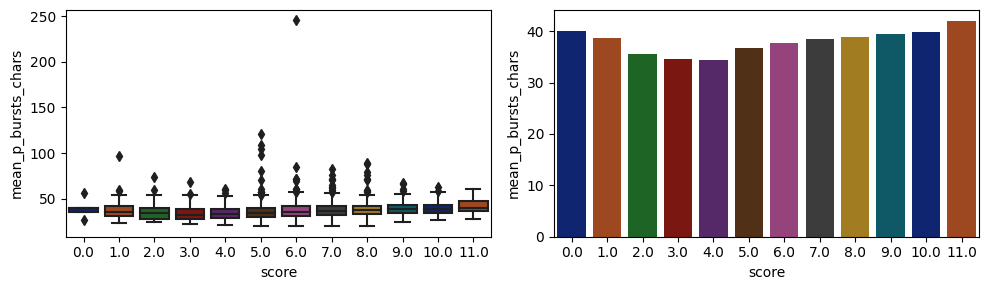

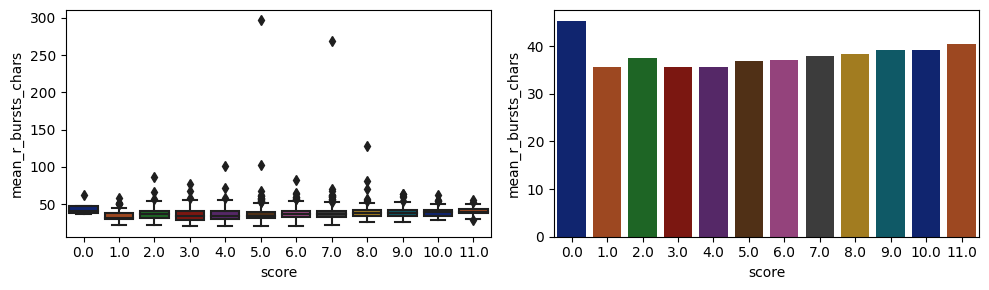

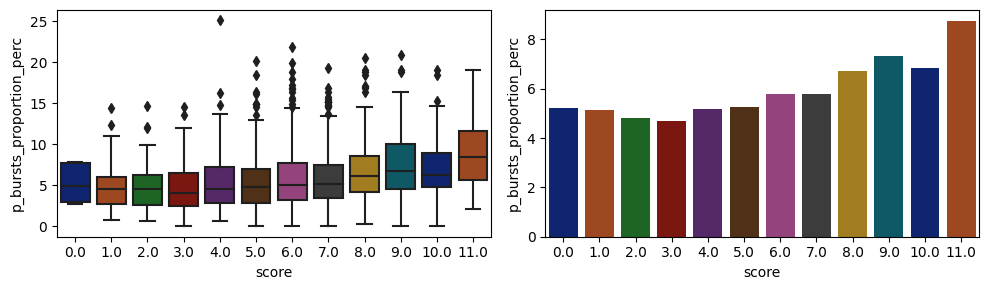

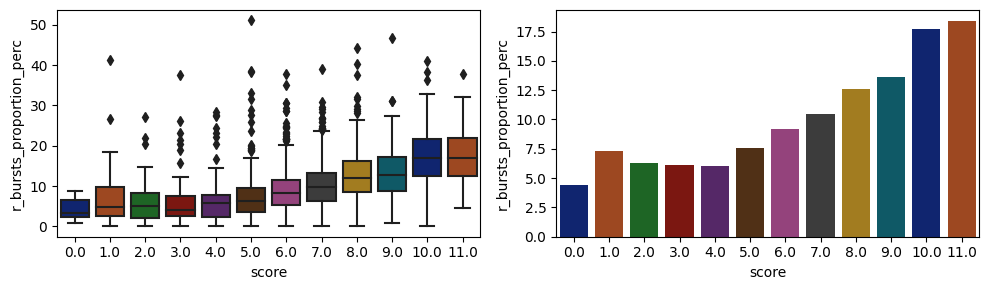

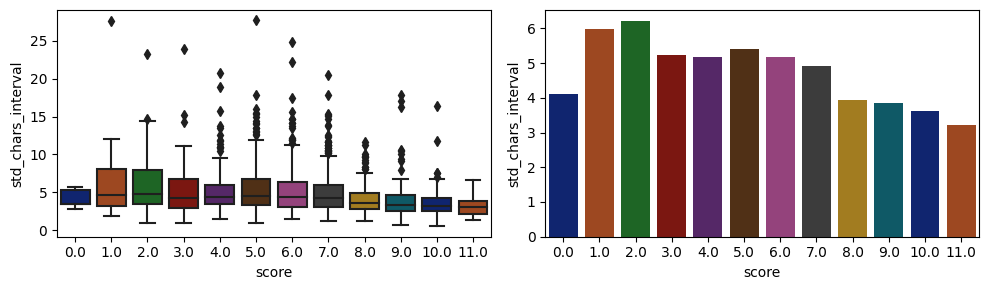

In [22]:
for column in simplified_train_logs.columns:
    if column not in ('num_control_key', 'num_events'):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.boxplot(x=train_scores.score, y=simplified_train_logs[column], palette='dark', ax=axes[0]);
        sns.barplot(x=train_scores.score, y=simplified_train_logs[column], ci=None, palette='dark', ax=axes[1]);
        plt.tight_layout()
        plt.show()

We can observe clearly some positive correlations with the features: `total_action_time_mins, chars_per_min_product,`

`chars_per_min_process, words_per_min_product, words_per_min_process, sentences_per_min_process, sentences_per_min_product,`

`deletions, deletions_per_min, imm_deletions, p_bursts, r_bursts, p_bursts_per_min, r_bursts_per_min,` 

`bursts_proportion_perc, r_bursts_proportion_perc`. There are negative correlations with the following features, as well:

`pause_time_proportion_perc, mean_pause_length_btw_sentences, mean_pause_length_btw_words,` 

`mean_pause_length_w_in_words`.

Afterwards, correlations among those features will be analyzed, and some of them will be descarded as a result.

In [23]:
# ver dif total_action_time vs total_time_mins, quiza quitando nonproduction se puede crear otra feature?

- **Other hypothesis to explore**:
    *  Best writers have more clarity of thought -> less corrections - keystroke features
    
    *  Best writers spend a larger share of time reviewing - keystroke features

    *  Best writers spend a larger share of time thinking, in pause - keystroke features
    
    *  Best writers spend a larger share of time in bursts (better short-term memory) - keystroke features
    
    *  Volume-related events: tendency to get distracted - tiny sample 
    
    *  Volume-related events: focused if shutting down noise  - tiny sample
    
    *  Those with more periods of inactivity have lower performance - keystroke features
    
<br>


Several hypotheses were rejected due to the limited sample sizes, while others required the introduction of novel features

(keystroke features created in the file 'keystroke-measures'). The efficacy of these newly introduced features will be

assessed by machine learning models to ascertain their utility or lack thereof.

### Feature Engineering

In [24]:
# simplified_train_logs = simplified_train_logs.merge(train_scores.drop('id', axis=1), left_index=True, right_index=True)

In [25]:
print("Null Values found in simplified_train_logs:\n")
print(simplified_train_logs.isna().sum().sort_values(ascending=False)[:6])
simplified_train_logs.fillna(0, inplace=True)

Null Values found in simplified_train_logs:

mean_pause_length_btw_paragraphs    614
mean_r_bursts_chars                  30
mean_pause_length_btw_sentences      20
mean_p_bursts_chars                   9
mean_length_deletions                 1
distant_deletion_ratio                1
dtype: int64


In [26]:
simplified_train_logs.columns

Index(['num_events', 'total_time_mins', 'total_action_time_mins',
       'mean_action_time_ms', 'chars_per_min_product', 'chars_per_min_process',
       'words_per_min_product', 'words_per_min_process',
       'sentences_per_min_process', 'sentences_per_min_product',
       'paragraphs_per_min_process', 'pauses_per_min',
       'pause_time_proportion_perc', 'mean_pause_length',
       'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
       'mean_pause_length_btw_words', 'mean_pause_length_w_in_words',
       'deletions', 'deletions_per_min', 'mean_length_deletions',
       'distant_deletions', 'deletions_proportion_perc', 'imm_deletions',
       'distant_deletion_ratio', 'product_process_ratio', 'p_bursts',
       'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
       'mean_p_bursts_chars', 'mean_r_bursts_chars',
       'p_bursts_proportion_perc', 'r_bursts_proportion_perc',
       'std_chars_interval', 'num_control_key'],
      dtype='object')

In [27]:
# feature clusters
production_cluster = ['chars_per_min_product', 'chars_per_min_process', 'words_per_min_product', 
                      'words_per_min_process', 'sentences_per_min_process', 'sentences_per_min_product',
                      'paragraphs_per_min_process']
pause_cluster = ['pauses_per_min', 'pause_time_proportion_perc', 'mean_pause_length', 
                 'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
                 'mean_pause_length_btw_words', 'mean_pause_length_w_in_words']
deletions_cluster = ['deletions', 'deletions_per_min', 'mean_length_deletions', 'distant_deletions', 
                     'deletions_proportion_perc', 'imm_deletions', 'distant_deletion_ratio']
bursts_cluster = ['p_bursts', 'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
                  'mean_p_bursts_chars', 'mean_r_bursts_chars', 'p_bursts_proportion_perc', 
                  'r_bursts_proportion_perc']

feature_clusters = [production_cluster, pause_cluster, deletions_cluster, bursts_cluster]
feature_clusters_str = ['production cluster', 'pause cluster', 'deletions cluster', 'bursts cluster']

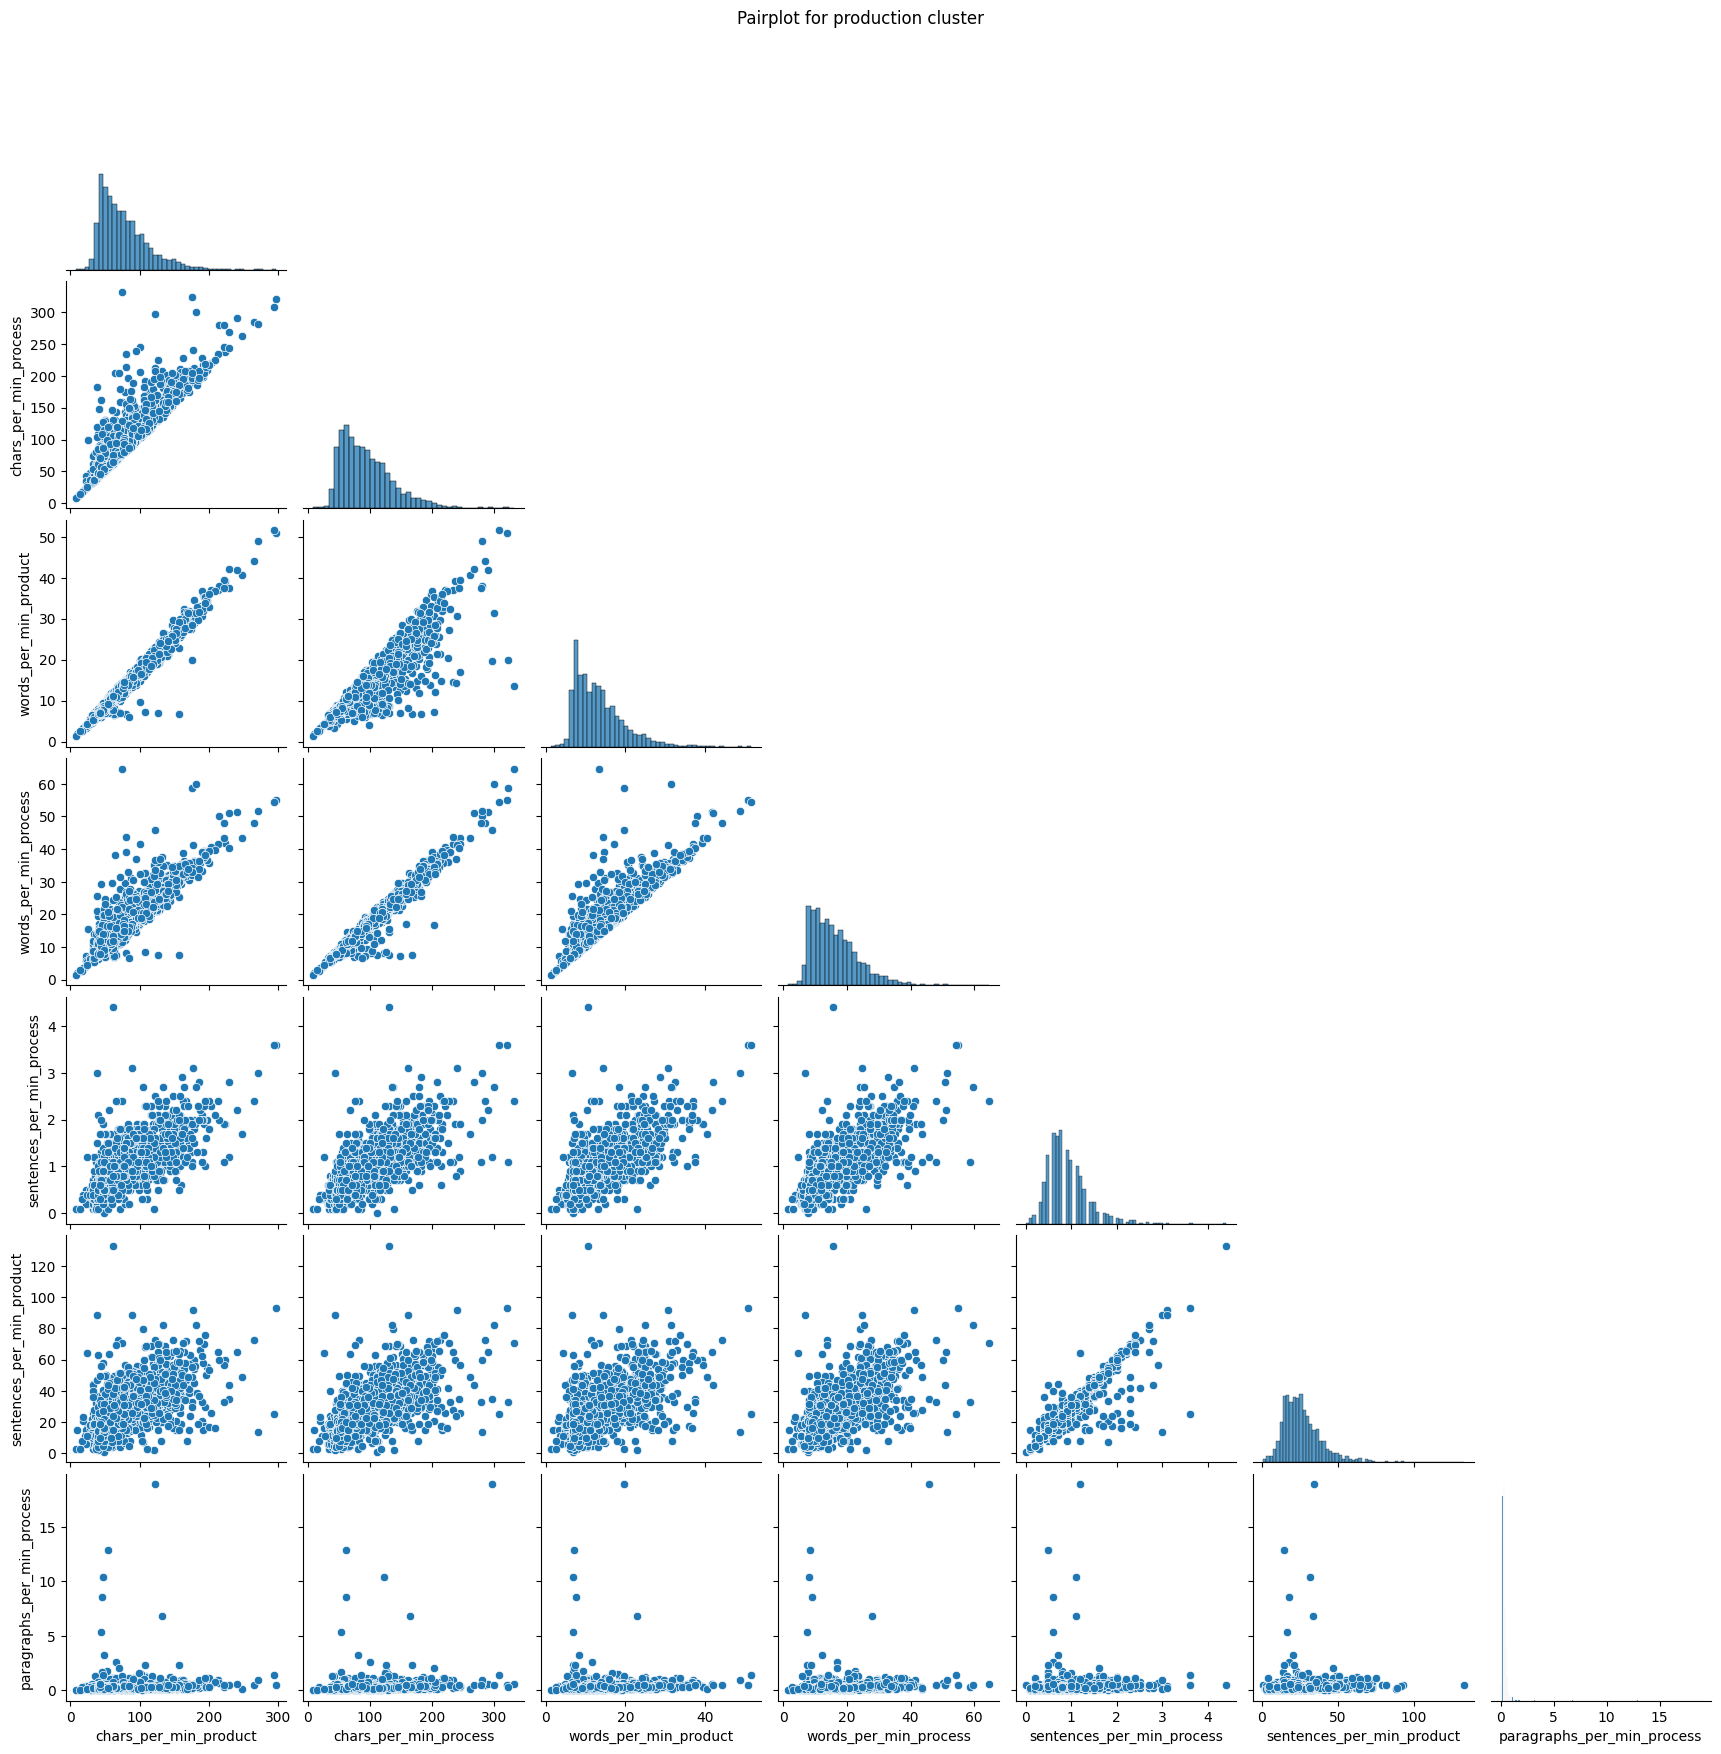

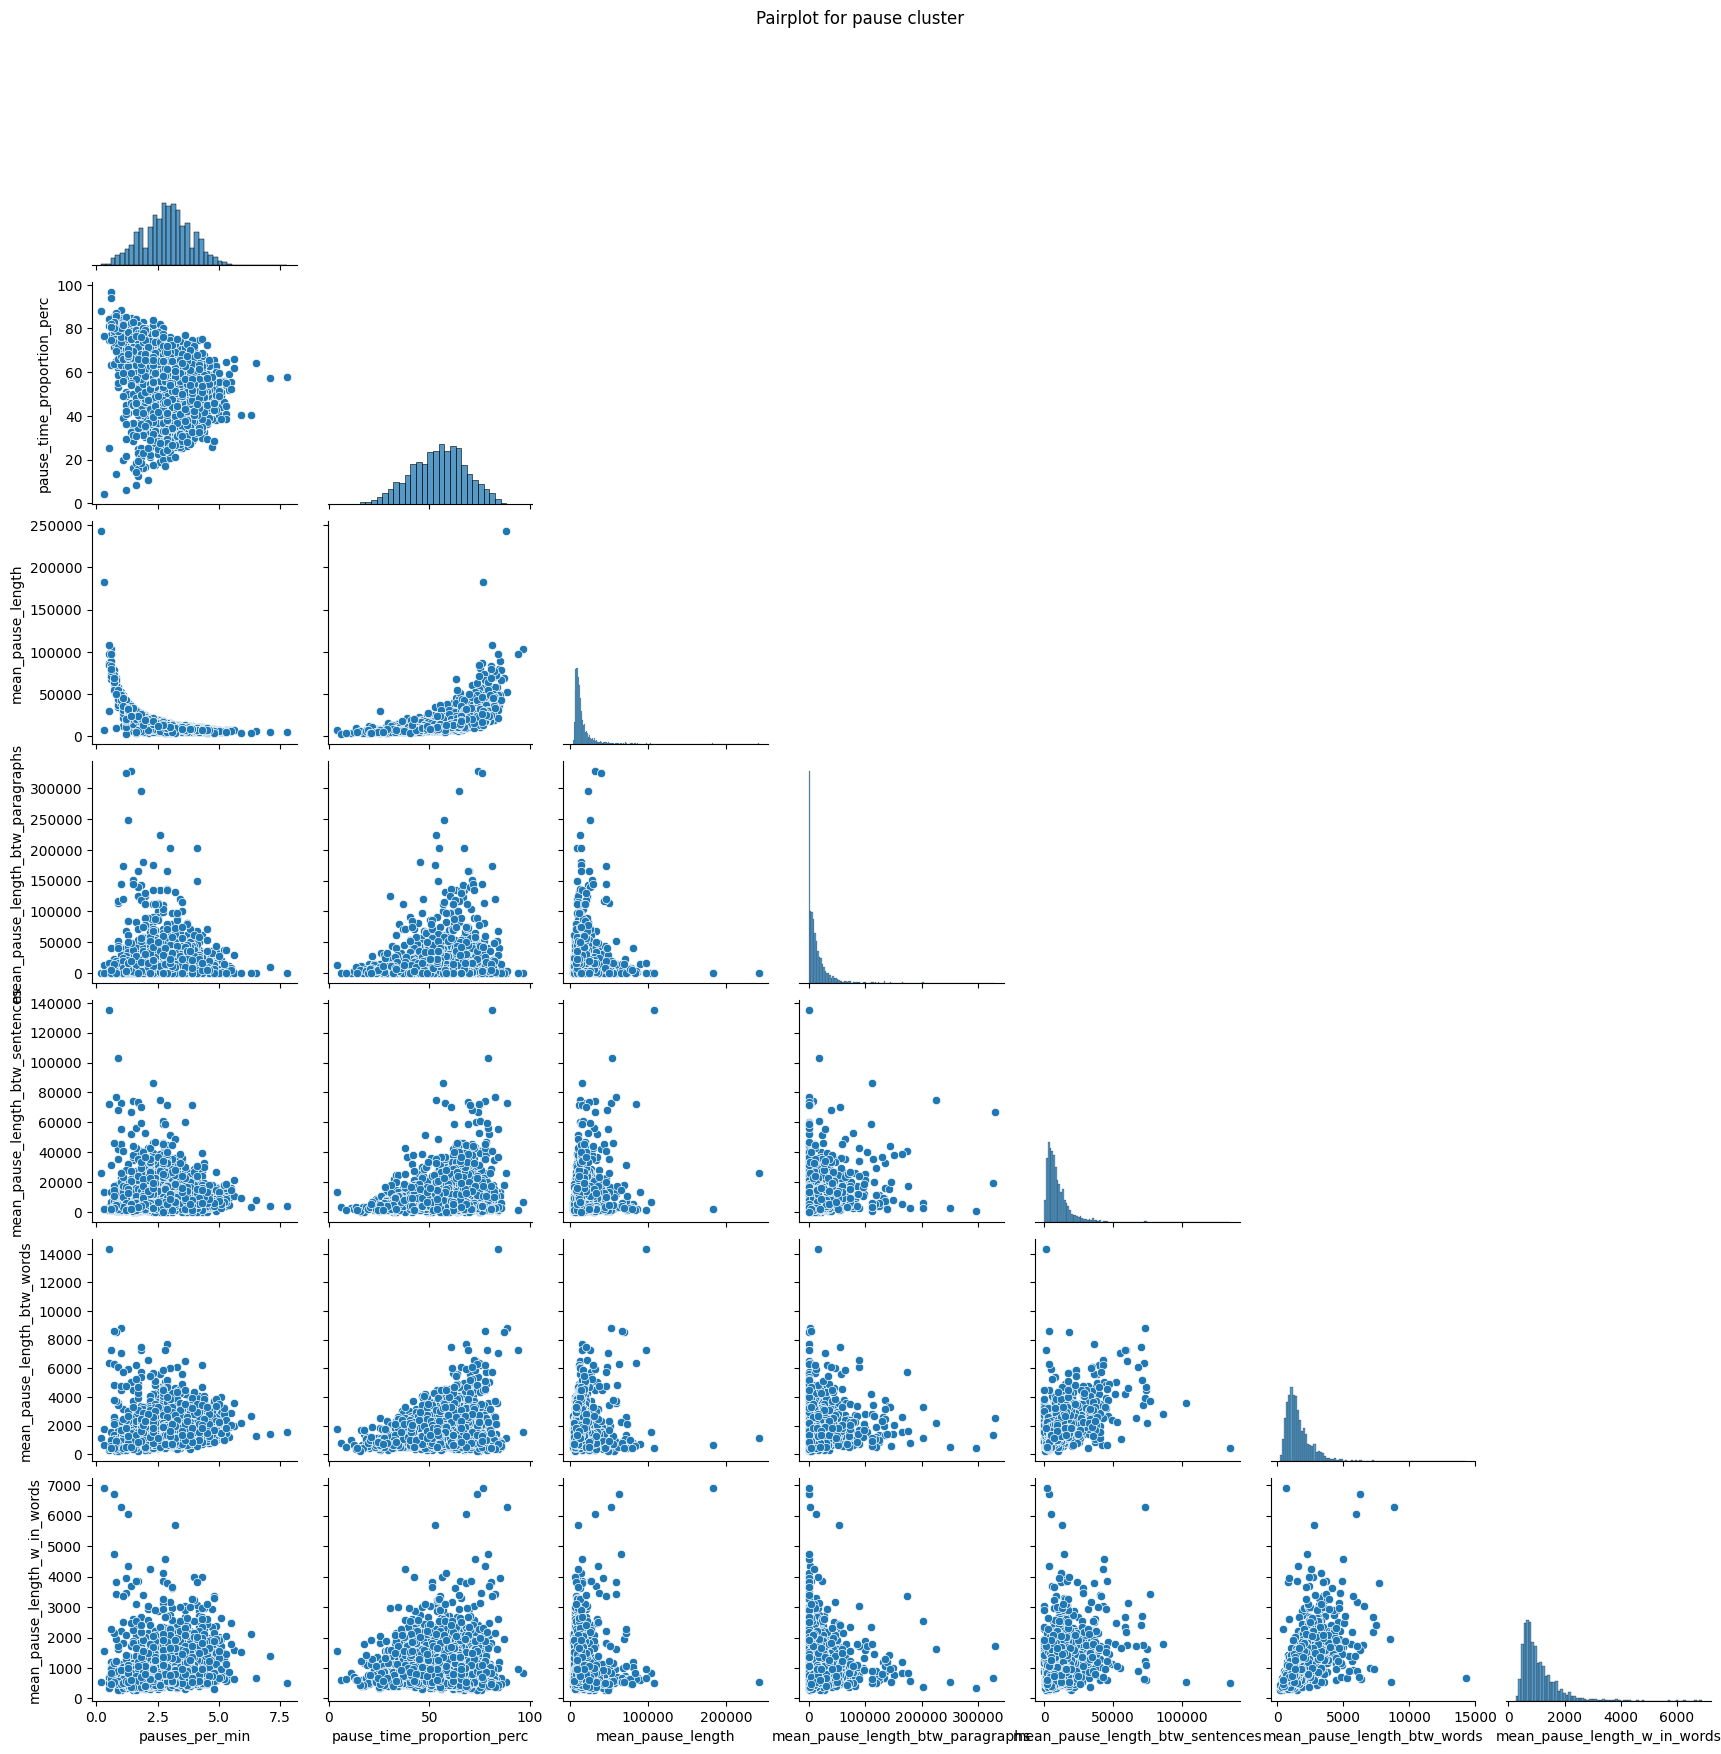

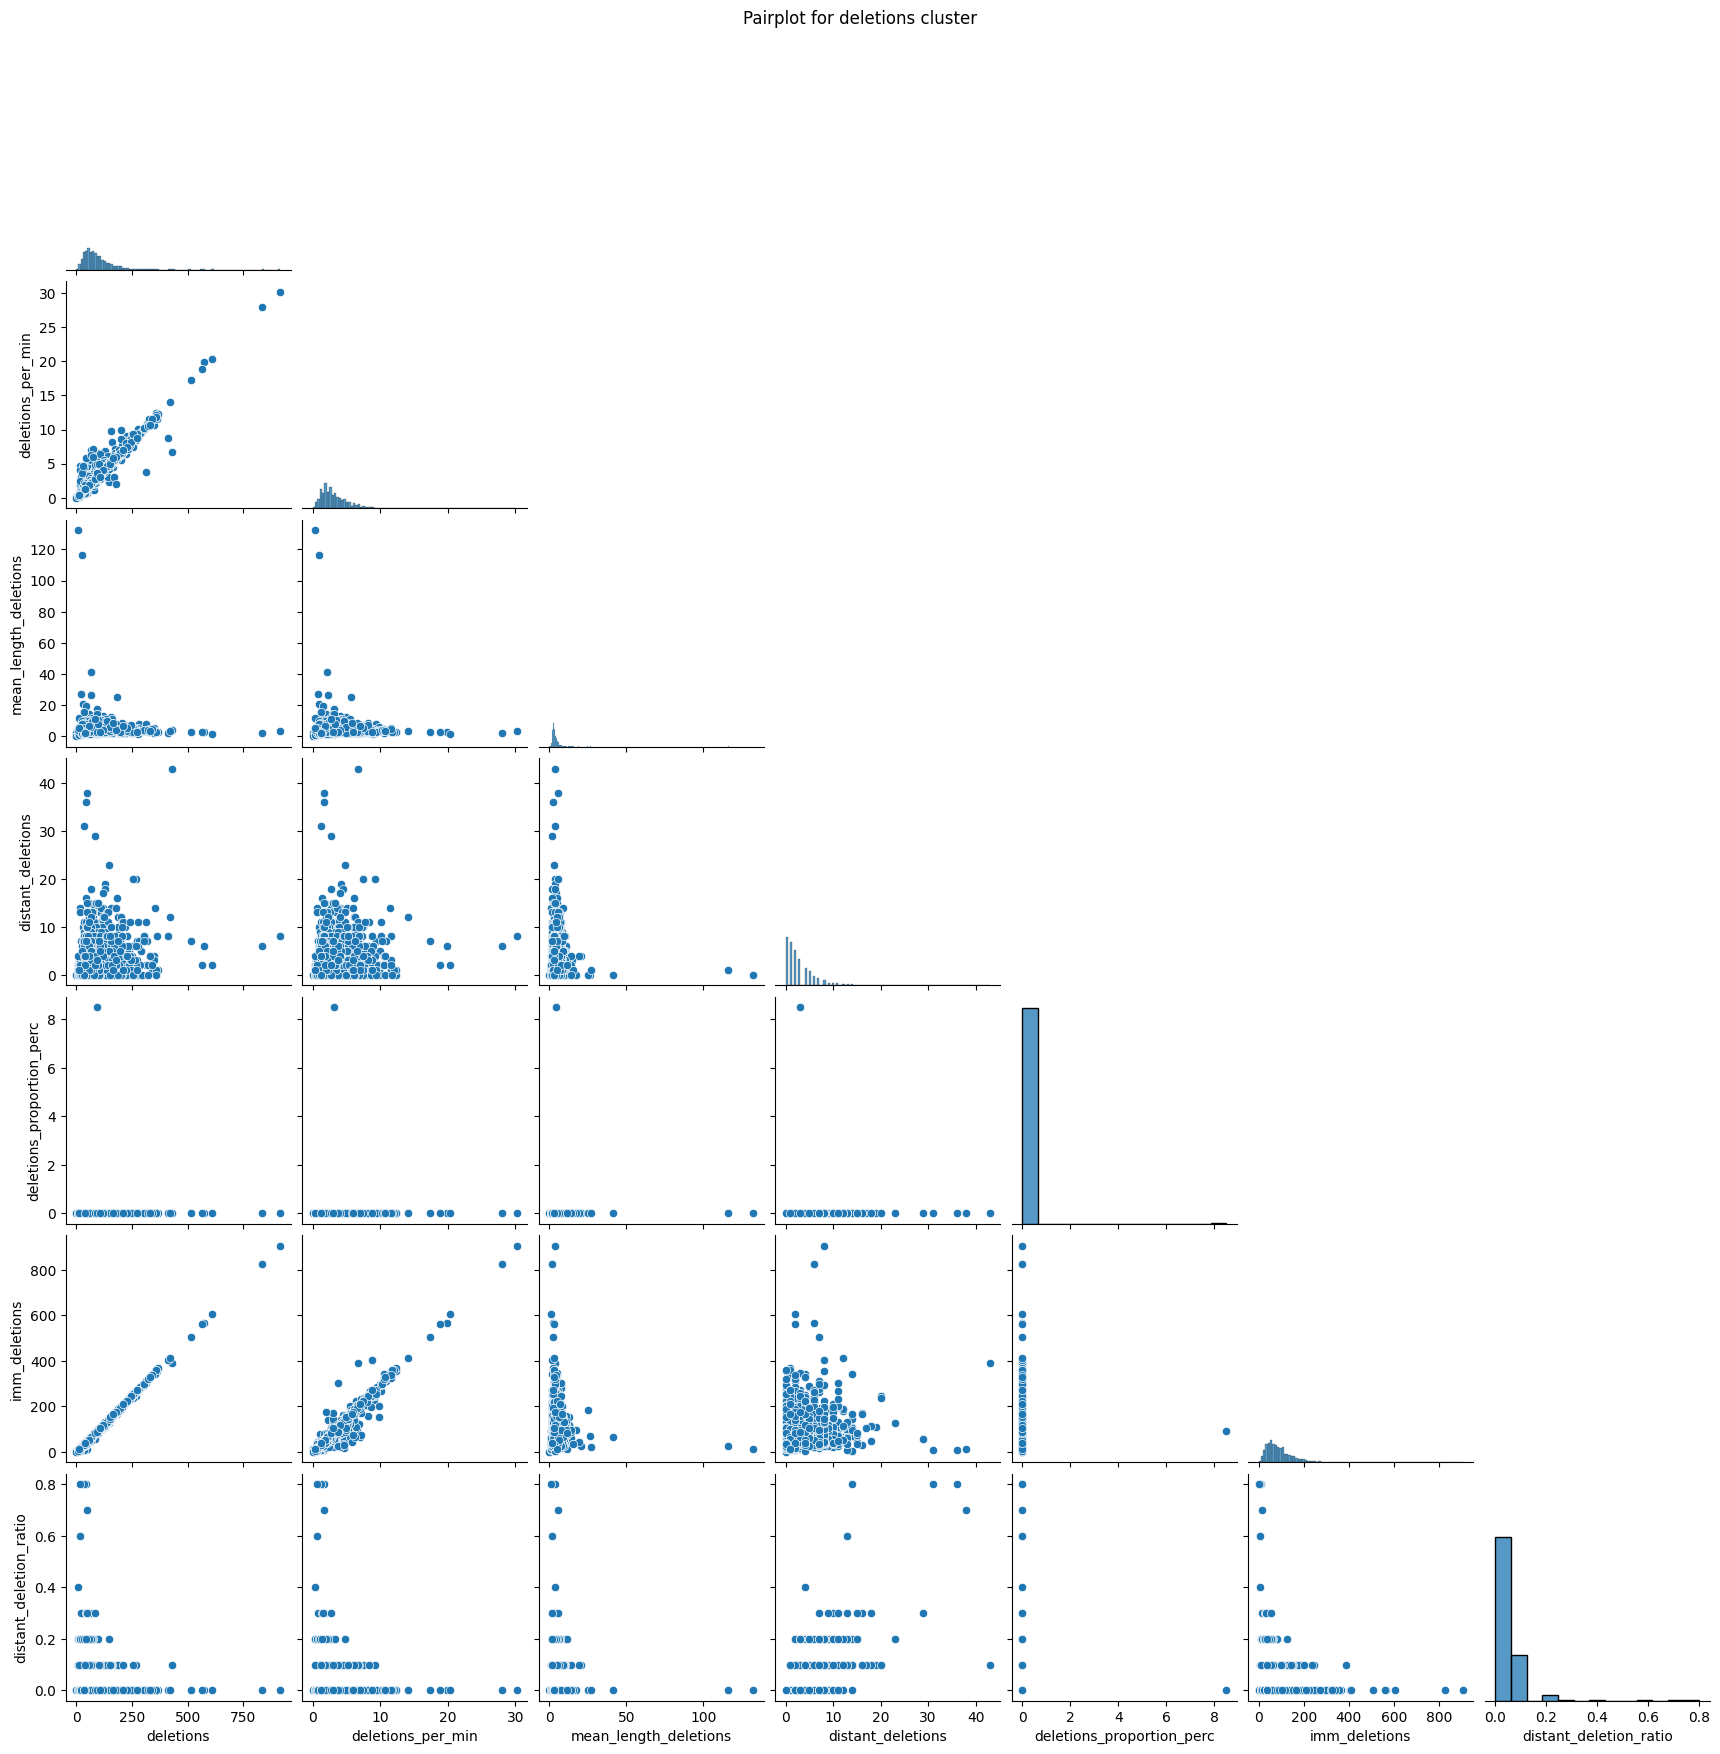

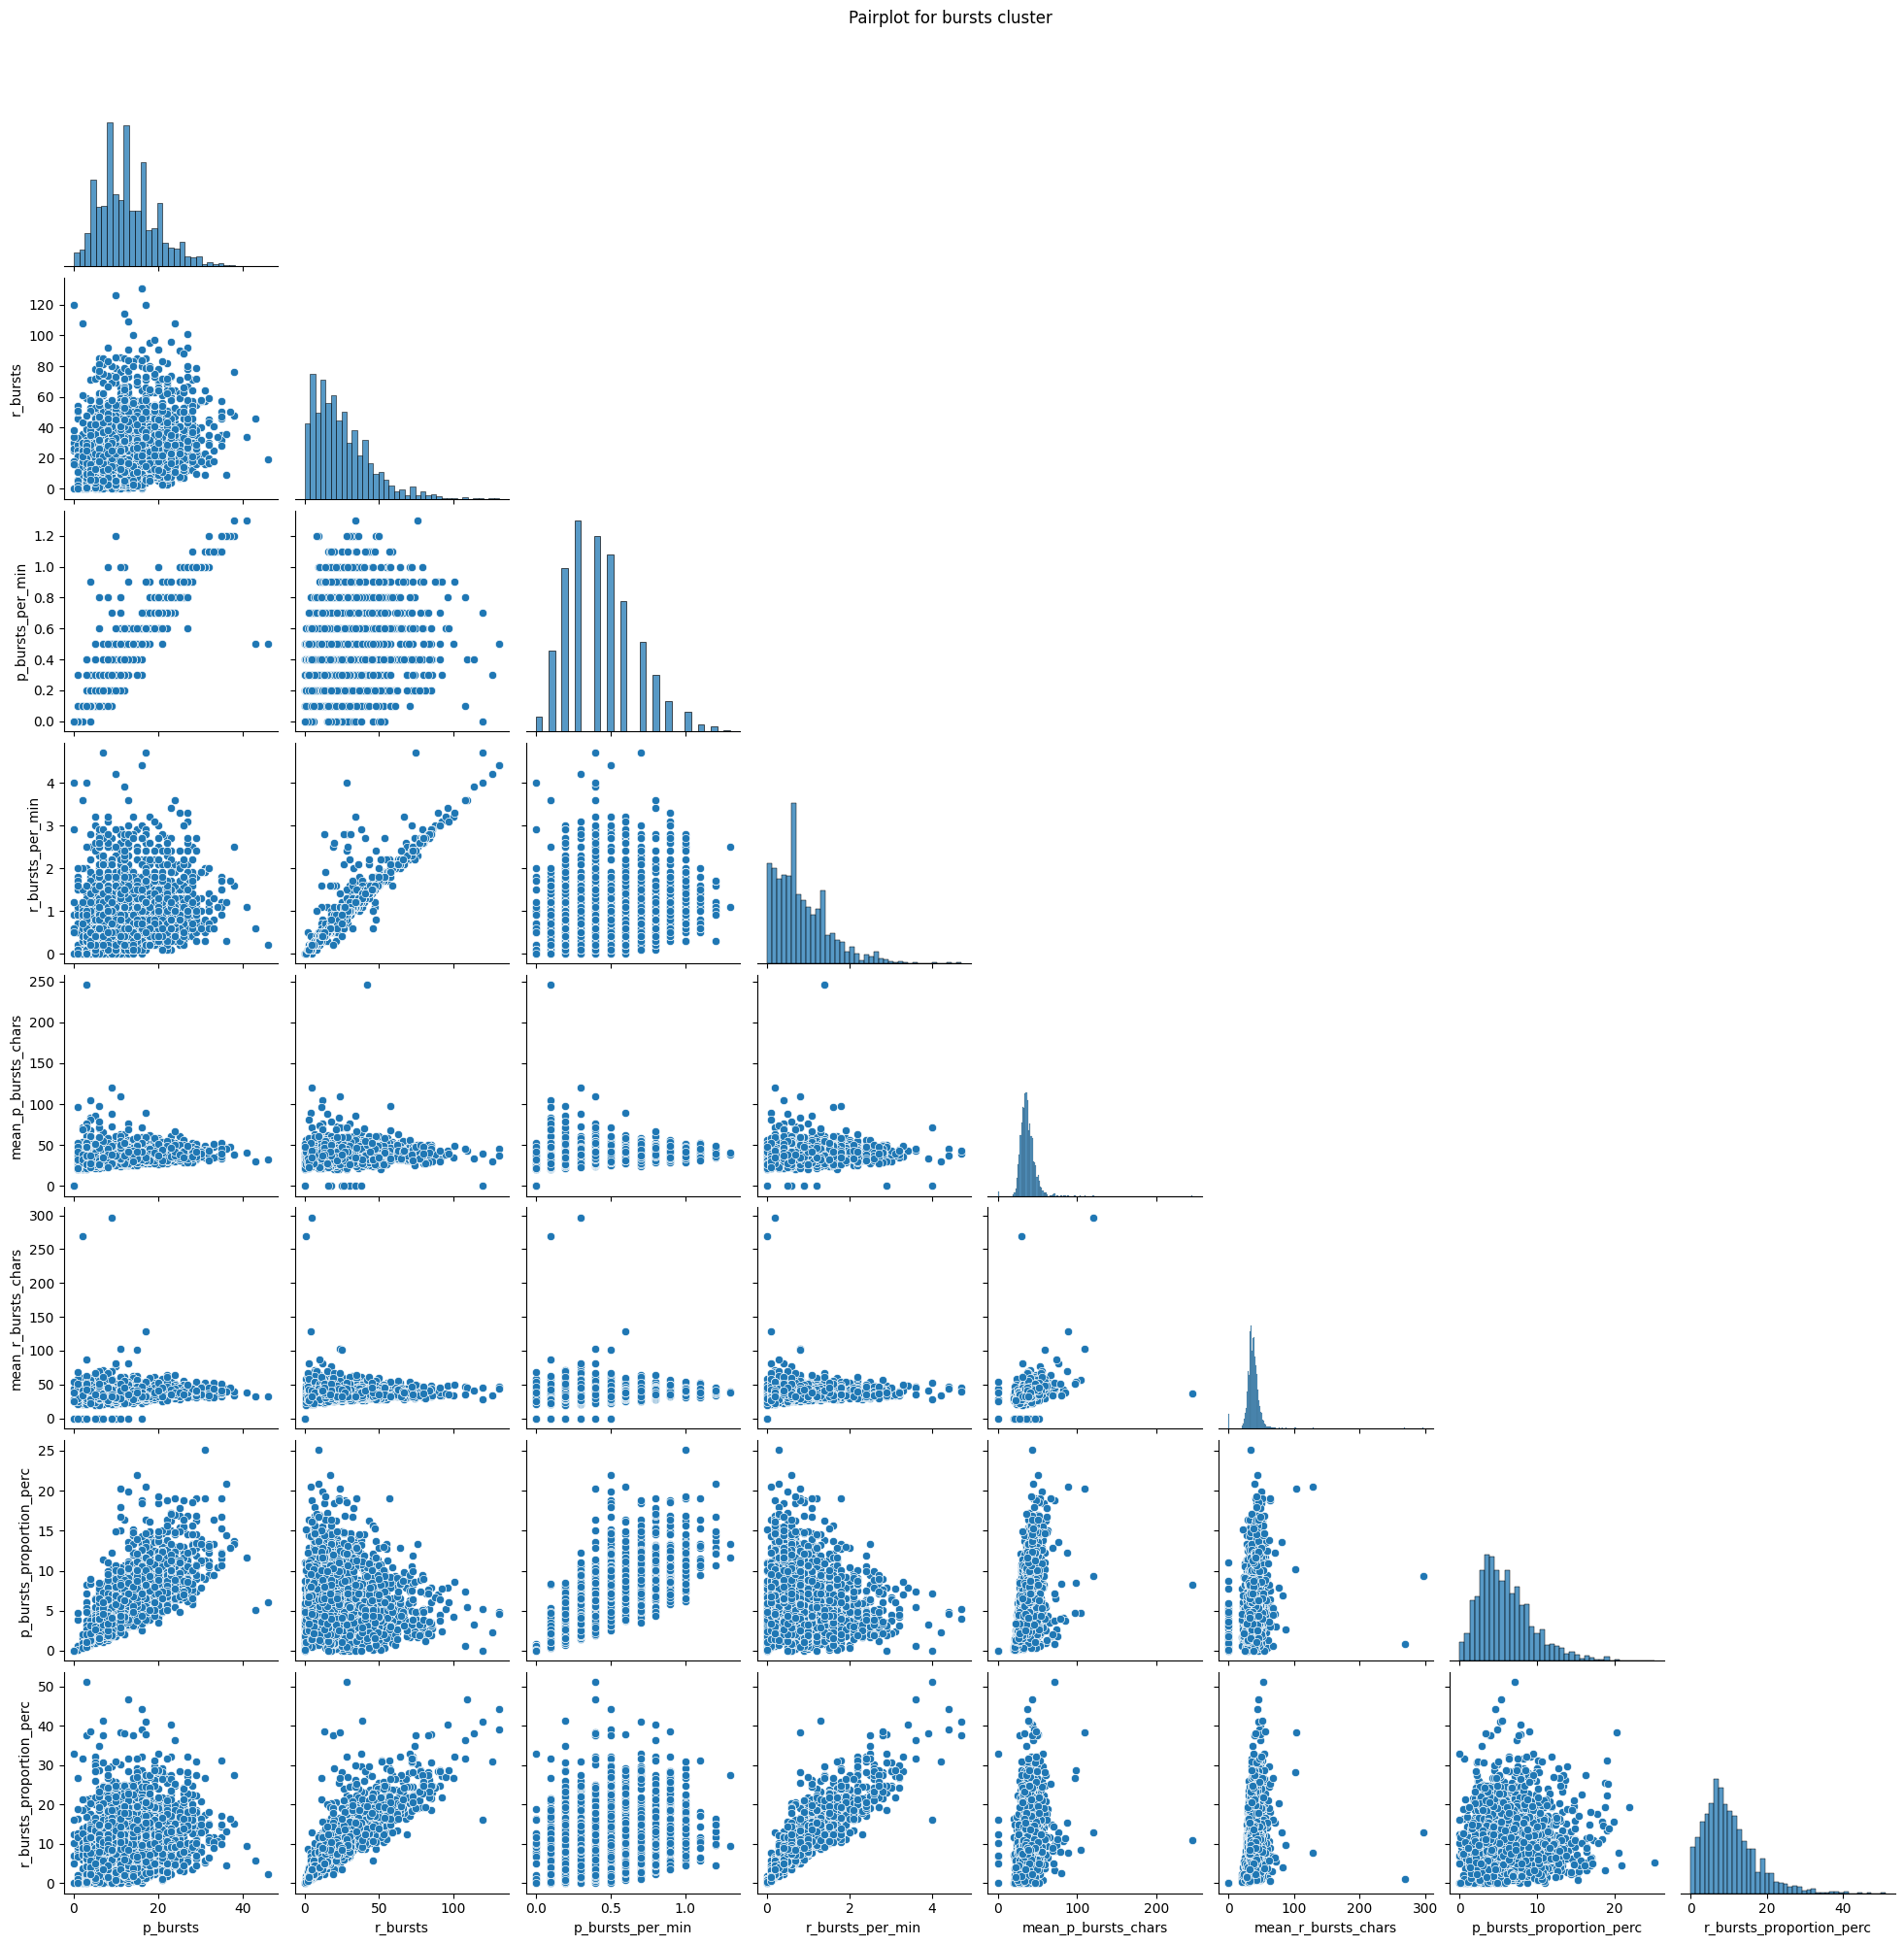

In [28]:
for i, feature_cluster in enumerate(feature_clusters):
    pair_plot = sns.pairplot(simplified_train_logs[feature_cluster], corner=True)
    pair_plot.fig.suptitle(f'Pairplot for {feature_clusters_str[i]}', y=1.005)

In [29]:
highly_correl_cols = ['chars_per_min_product', 'words_per_min_process', 'imm_deletions', 
                      'deletions_per_min', 'r_bursts_per_min']
simplified_train_logs.drop(highly_correl_cols, axis=1, inplace=True)
len(simplified_train_logs.columns)

31

In [30]:
# delete highly_correl_cols from feature_clusters
feature_clusters = [list(set(cluster) - set(highly_correl_cols)) for cluster in feature_clusters]
feature_clusters

[['words_per_min_product',
  'chars_per_min_process',
  'sentences_per_min_process',
  'paragraphs_per_min_process',
  'sentences_per_min_product'],
 ['pause_time_proportion_perc',
  'mean_pause_length_btw_sentences',
  'mean_pause_length_w_in_words',
  'mean_pause_length_btw_words',
  'pauses_per_min',
  'mean_pause_length',
  'mean_pause_length_btw_paragraphs'],
 ['deletions_proportion_perc',
  'deletions',
  'distant_deletion_ratio',
  'mean_length_deletions',
  'distant_deletions'],
 ['p_bursts',
  'p_bursts_proportion_perc',
  'p_bursts_per_min',
  'mean_r_bursts_chars',
  'r_bursts',
  'mean_p_bursts_chars',
  'r_bursts_proportion_perc']]

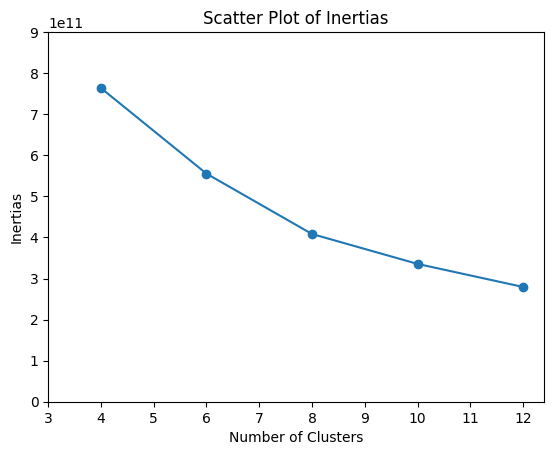

In [31]:
# to apply after split
from sklearn.cluster import KMeans
inertias = {}
for n_clusters in [4, 6, 8, 10, 12]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(simplified_train_logs)
#     simplified_train_logs['kmeans_clusters'] = kmeans.labels_
    kmeans.labels_
#     print(f'\nValue counts for {n_clusters} clusters:\n', 
#           simplified_train_logs['kmeans_clusters'].value_counts())
    inertias[n_clusters] = kmeans.inertia_

num_clusters = list(inertias.keys())
inertias = list(inertias.values())

plt.plot(num_clusters, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('Scatter Plot of Inertias')
plt.xticks(range(3, n_clusters+1, 1));
plt.yticks(range(0, 10*int(1e11), int(1e11)));

In [32]:
# plan to use tree-based models

# log transformation for skewed variables - 
# Assumption in Tree-Based Models: While tree-based models are robust 
# to the scale of features, skewed distributions may still impact the performance, 
# especially when it comes to the ability to split the data effectively.

# Also can mitigate the impact of outliers, making the tree more robust.

# Tree-based models are less sensitive to heteroscedasticity compared 
# to linear models. However, stabilizing the variance in features can 
# still contribute to a more stable and robust model.

#  If the data has a less extreme right-skewness, square root (or cube root - 
# reduces the right skewness) transformation might be more appropriate. 
# x^2 helps reduce left skewness. If the skewness is more pronounced and the 
# values span several orders of magnitude, log transformation might be a better choice.

# apply .skew() to transformation after scaling


	- PCA with 4 components:

                           Comp1     Comp2     Comp3     Comp4
Proportion of Variance  0.285157  0.109091  0.084962  0.053111

 4 components account for 53.23% of the variance.

	- PCA with 8 components:

                           Comp1     Comp2     Comp3     Comp4     Comp5  \
Proportion of Variance  0.285157  0.109091  0.084963  0.053113  0.047257   

                           Comp6     Comp7     Comp8  
Proportion of Variance  0.042575  0.039239  0.037168  

 8 components account for 69.86% of the variance.

	- PCA with 12 components:

                           Comp1     Comp2     Comp3     Comp4     Comp5  \
Proportion of Variance  0.285157  0.109091  0.084963  0.053113  0.047257   

                           Comp6    Comp7     Comp8     Comp9    Comp10  \
Proportion of Variance  0.042575  0.03924  0.037169  0.034007  0.032456   

                          Comp11    Comp12  
Proportion of Variance  0.031727  0.029368  

 12 components account for 82

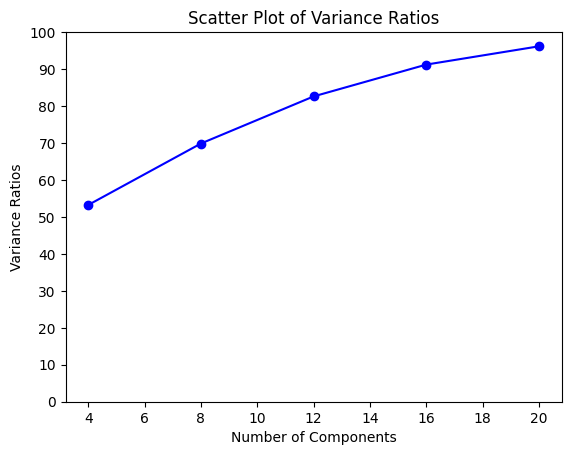

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
simplified_train_logs_scaled = scaler.fit_transform(simplified_train_logs)

# Loop over the number of PCA components
var_ratios = {}
for n_components in [4, 8, 12, 16, 20]:
    print(f'\n\t- PCA with {n_components} components:\n')
    
    # Perform PCA
    logs_pca = PCA(n_components=n_components, random_state=SEED)
    logs_pca.fit(simplified_train_logs_scaled)
    
    # Variance ratio
    var_ratio = logs_pca.explained_variance_ratio_
    var_ratio = pd.DataFrame(var_ratio).transpose()
    var_ratio.columns = [f'Comp{i}' for i in range(1, n_components + 1)]
    var_ratio.index = ['Proportion of Variance']
    print(var_ratio)
    
    print('\n', 
          f'{n_components} components account for',
          f'{np.round(var_ratio.sum().sum() * 100, 2)}% of the variance.')
    
    var_ratios[n_components] = np.round(var_ratio.sum().sum() * 100, 2)


#     logs_pcomp = logs_pca.transform(simplified_train_logs_scaled)
#     logs_pcomp = pd.DataFrame(logs_pcomp[:, :n_components],
#                               columns=[f'Comp{i}' for i in range(1, n_components + 1)])
#     print(logs_pcomp.head())
print('\n')
keys = list(var_ratios.keys())
values = list(var_ratios.values())

plt.plot(keys, values, color='blue', marker='o', label='Variance Ratios')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratios')
plt.title('Scatter Plot of Variance Ratios')
plt.yticks(range(0, 101, 10));

In [34]:
# pca - chatgpt on splitting first
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # Step 1: Split the data
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# # Step 2: Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Step 3 and 4: Apply PCA on training data and transform
# pca = PCA(n_components=desired_num_components)
# X_train_pca = pca.fit_transform(X_train_scaled)

# # Step 5: Apply the same transformation to test data
# X_test_pca = pca.transform(X_test_scaled)

### Baseline with Random Forest Classifier

In [35]:
train_scores.score.value_counts()

score
7.0     501
6.0     486
8.0     402
5.0     336
4.0     201
9.0     179
10.0    128
3.0      92
2.0      69
11.0     37
1.0      35
0.0       5
Name: count, dtype: int64

In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=SEED)

X = simplified_train_logs
y = train_scores.score

num_folds = 5
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=stratified_kfold, scoring='accuracy')

# Display the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.round(cv_scores.mean(), 1))

Cross-validation scores: [0.35353535 0.30161943 0.33805668 0.32591093 0.31983806]
Mean accuracy: 0.3


In [37]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

clf = RandomForestClassifier(random_state=SEED)

X = simplified_train_logs
y = train_scores.score

num_folds = 5
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
y_pred = cross_val_predict(clf, X, y, cv=stratified_kfold)
classes = np.unique(y)

# Initialize lists to store metrics for each class
precision_scores = []
recall_scores = []
accuracy_scores = []

for class_label in classes:
    class_indices = (y == class_label)
    y_true_class = y[class_indices]
    y_pred_class = y_pred[class_indices]

    # Calculate precision, recall, and accuracy for each class
    precision = precision_score(y_true_class, y_pred_class, average='weighted')
    recall = recall_score(y_true_class, y_pred_class, average='weighted')
    accuracy = accuracy_score(y_true_class, y_pred_class)

    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    # Display metrics for each class
    print(f"Class {class_label}: Precision = {precision:.2f}, Recall = {recall:.2f}, Accuracy = {accuracy:.2f}")

# Display overall metrics
print("\nOverall Metrics:")
print("Mean Precision:", np.round(np.mean(precision_scores),1))
print("Mean Recall:", np.round(np.mean(recall_scores),1))
print("Mean Accuracy:", np.round(np.mean(accuracy_scores),1))

Class 0.0: Precision = 0.00, Recall = 0.00, Accuracy = 0.00
Class 1.0: Precision = 1.00, Recall = 0.06, Accuracy = 0.06
Class 2.0: Precision = 1.00, Recall = 0.04, Accuracy = 0.04
Class 3.0: Precision = 1.00, Recall = 0.08, Accuracy = 0.08
Class 4.0: Precision = 1.00, Recall = 0.33, Accuracy = 0.33
Class 5.0: Precision = 1.00, Recall = 0.33, Accuracy = 0.33
Class 6.0: Precision = 1.00, Recall = 0.39, Accuracy = 0.39
Class 7.0: Precision = 1.00, Recall = 0.41, Accuracy = 0.41
Class 8.0: Precision = 1.00, Recall = 0.44, Accuracy = 0.44
Class 9.0: Precision = 1.00, Recall = 0.11, Accuracy = 0.11
Class 10.0: Precision = 1.00, Recall = 0.26, Accuracy = 0.26
Class 11.0: Precision = 0.00, Recall = 0.00, Accuracy = 0.00

Overall Metrics:
Mean Precision: 0.8
Mean Recall: 0.2
Mean Accuracy: 0.2


### Baseline with XGB Classifier

In [38]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier  # Import XGBClassifier from the xgboost library

clf = XGBClassifier(random_state=SEED)  # Use XGBClassifier instead of RandomForestClassifier

X = simplified_train_logs
y = train_scores.score

num_folds = 5
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=stratified_kfold, scoring='accuracy')

# Display the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.round(cv_scores.mean(),1))


Cross-validation scores: [0.32121212 0.30566802 0.29352227 0.27327935 0.30769231]
Mean accuracy: 0.3


In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

clf = XGBClassifier(random_state=SEED)

X = simplified_train_logs
y = train_scores.score

num_folds = 5
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
y_pred = cross_val_predict(clf, X, y, cv=stratified_kfold)
classes = np.unique(y)

# Initialize lists to store metrics for each class
precision_scores = []
recall_scores = []
accuracy_scores = []

for class_label in classes:
    class_indices = (y == class_label)
    y_true_class = y[class_indices]
    y_pred_class = y_pred[class_indices]

    # Calculate precision, recall, and accuracy for each class
    precision = precision_score(y_true_class, y_pred_class, average='weighted')
    recall = recall_score(y_true_class, y_pred_class, average='weighted')
    accuracy = accuracy_score(y_true_class, y_pred_class)

    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    # Display metrics for each class
    print(f"Class {class_label}: Precision = {precision:.2f}, Recall = {recall:.2f}, Accuracy = {accuracy:.2f}")

# Display overall metrics
print("\nOverall Metrics:")
print("Mean Precision:", np.round(np.mean(precision_scores),1))
print("Mean Recall:", np.round(np.mean(recall_scores),1))
print("Mean Accuracy:", np.round(np.mean(accuracy_scores),1))

Class 0.0: Precision = 0.00, Recall = 0.00, Accuracy = 0.00
Class 1.0: Precision = 1.00, Recall = 0.03, Accuracy = 0.03
Class 2.0: Precision = 1.00, Recall = 0.09, Accuracy = 0.09
Class 3.0: Precision = 1.00, Recall = 0.07, Accuracy = 0.07
Class 4.0: Precision = 1.00, Recall = 0.32, Accuracy = 0.32
Class 5.0: Precision = 1.00, Recall = 0.25, Accuracy = 0.25
Class 6.0: Precision = 1.00, Recall = 0.37, Accuracy = 0.37
Class 7.0: Precision = 1.00, Recall = 0.37, Accuracy = 0.37
Class 8.0: Precision = 1.00, Recall = 0.39, Accuracy = 0.39
Class 9.0: Precision = 1.00, Recall = 0.13, Accuracy = 0.13
Class 10.0: Precision = 1.00, Recall = 0.23, Accuracy = 0.23
Class 11.0: Precision = 1.00, Recall = 0.03, Accuracy = 0.03

Overall Metrics:
Mean Precision: 0.9
Mean Recall: 0.2
Mean Accuracy: 0.2
